In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
# Function to load data and print data types
def load_data(file_path):
    """
    Load data from the specified file path and handle data types.
    """
    data = pd.read_excel(file_path)
    
    # Convert columns to appropriate data types
    # List of columns that should be numeric
    numeric_columns = ['current_size', 'fire_location_latitude', 'fire_location_longitude',
                       'discovered_size', 'assessment_hectares', 'fire_spread_rate',
                       'temperature', 'relative_humidity', 'wind_speed', 'distance_from_water_source',
                       'bh_hectares', 'uc_hectares', 'to_hectares', 'ex_hectares']

    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, set errors to NaN
    
    # Print data types of all columns
    print(data.dtypes)
    
    return data

def main(file_path):
    """
    Main function to load data and print data types.
    """
    data = load_data(file_path)
    return data

if __name__ == "__main__":
    # Ensure the file path is correctly formatted for your OS
    file_path = r"https://open.alberta.ca/dataset/a221e7a0-4f46-4be7-9c5a-e29de9a3447e/resource/80480824-0c50-456c-9723-f9d4fc136141/download/fp-historical-wildfire-data-2006-2023.xlsx"
    main(file_path)



fire_year                         int64
fire_number                      object
fire_name                        object
current_size                    float64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
industry_identifier_desc         object
responsible_group_desc           object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
discovered_size                 float64
reported_date                    object
dispatched_resource              object
dispatch_date                    object
start_for_fire_date              object
assessment_resource              object
assessment_datetime              object
assessment_hectares             float64


In [89]:
# Summary for missing values
missing_summary = data.isna().sum()

print("Summary of missing values for each column:")
print(missing_summary)

Summary of missing values for each column:
fire_year                           0
fire_number                         0
fire_name                       24592
current_size                        0
size_class                          0
fire_location_latitude              0
fire_location_longitude             0
fire_origin                        16
general_cause_desc                  0
industry_identifier_desc        24859
responsible_group_desc          15938
activity_class                   9773
true_cause                      11770
fire_start_date                   681
det_agent_type                      0
det_agent                           0
discovered_date                  4941
discovered_size                 25175
reported_date                       0
dispatched_resource                17
dispatch_date                      17
start_for_fire_date                20
assessment_resource                 0
assessment_datetime                 0
assessment_hectares                 0
fire_sp

In [90]:
# Convert date columns to datetime
date_columns = ['fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 'dispatch_date', 'assessment_datetime','ia_arrival_at_fire_date', 'fire_fighting_start_size', 'first_bucket_drop_date', 'bh_fs_date', 'uc_fs_date', 'to_fs_date', 'ex_fs_date']

# Convert each column to datetime
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [91]:
# Create a function to calculate fire_duration (in minutes)
def calculate_fire_duration(row):
    if pd.notnull(row['fire_start_date']):
        return (row['ex_fs_date'] - row['fire_start_date']).total_seconds() / 60
    elif pd.notnull(row['discovered_date']):
        return (row['ex_fs_date'] - row['discovered_date']).total_seconds() / 60
    elif pd.notnull(row['reported_date']):
        return (row['ex_fs_date'] - row['reported_date']).total_seconds() / 60
    else:
        return pd.NaT

# Apply the function row-wise to calculate fire_duration
data['fire_duration'] = data.apply(calculate_fire_duration, axis=1)

In [92]:
# Calculate the correlation between fire_duration and current_size
correlation_value = data['fire_duration'].corr(data['current_size'])

print(f"Correlation between fire_duration and current_size: {correlation_value}, indicating a weak positive linear relationship")

Correlation between fire_duration and current_size: 0.13294338799031138, indicating a weak positive linear relationship


In [93]:
# Create a location column
# Extracting the first letter into a new column 'location'
data['location'] = data['fire_number'].str[0]

# Mapping dictionary for location
location_map = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}

# Replace the values in 'location' column using the mapping dictionary
data['location'].replace(location_map, inplace=True)

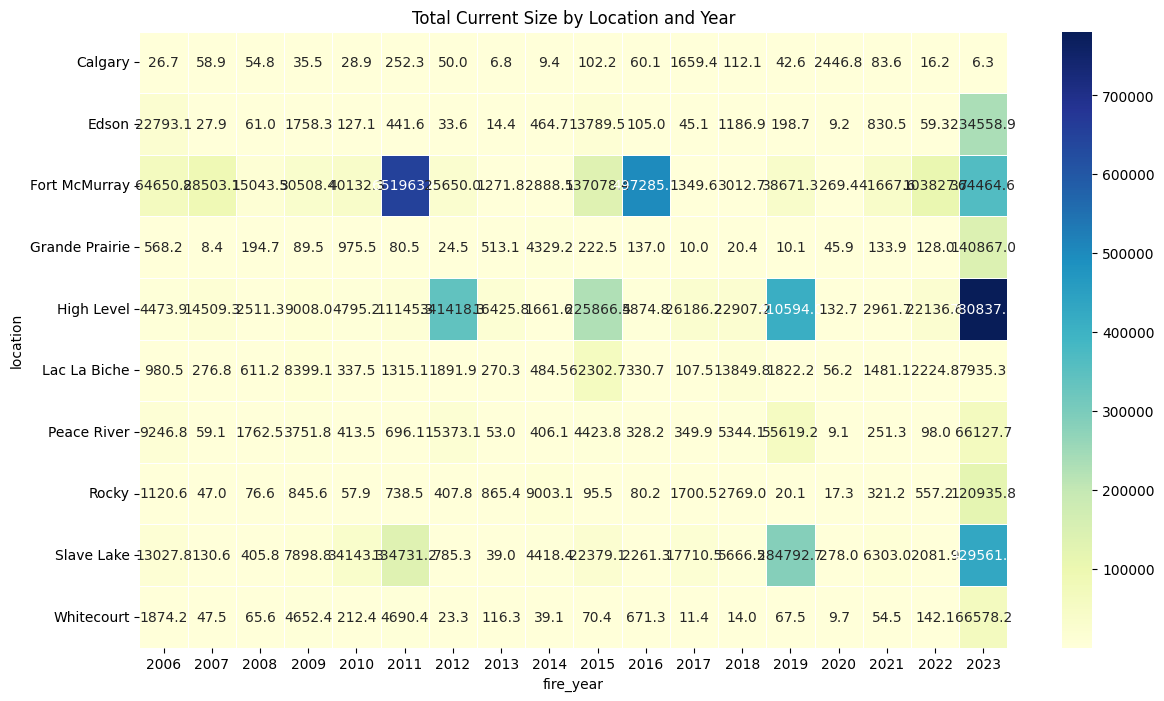

In [94]:
# Group by 'location' and 'fire_year' and calculate the total current_size
grouped_location_year = data.groupby(['location', 'fire_year']).agg({'current_size': 'sum'}).reset_index()

# Pivot the table to get years as columns and locations as rows
pivot_table = grouped_location_year.pivot(index='location', columns='fire_year', values='current_size')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Current Size by Location and Year')
plt.show()

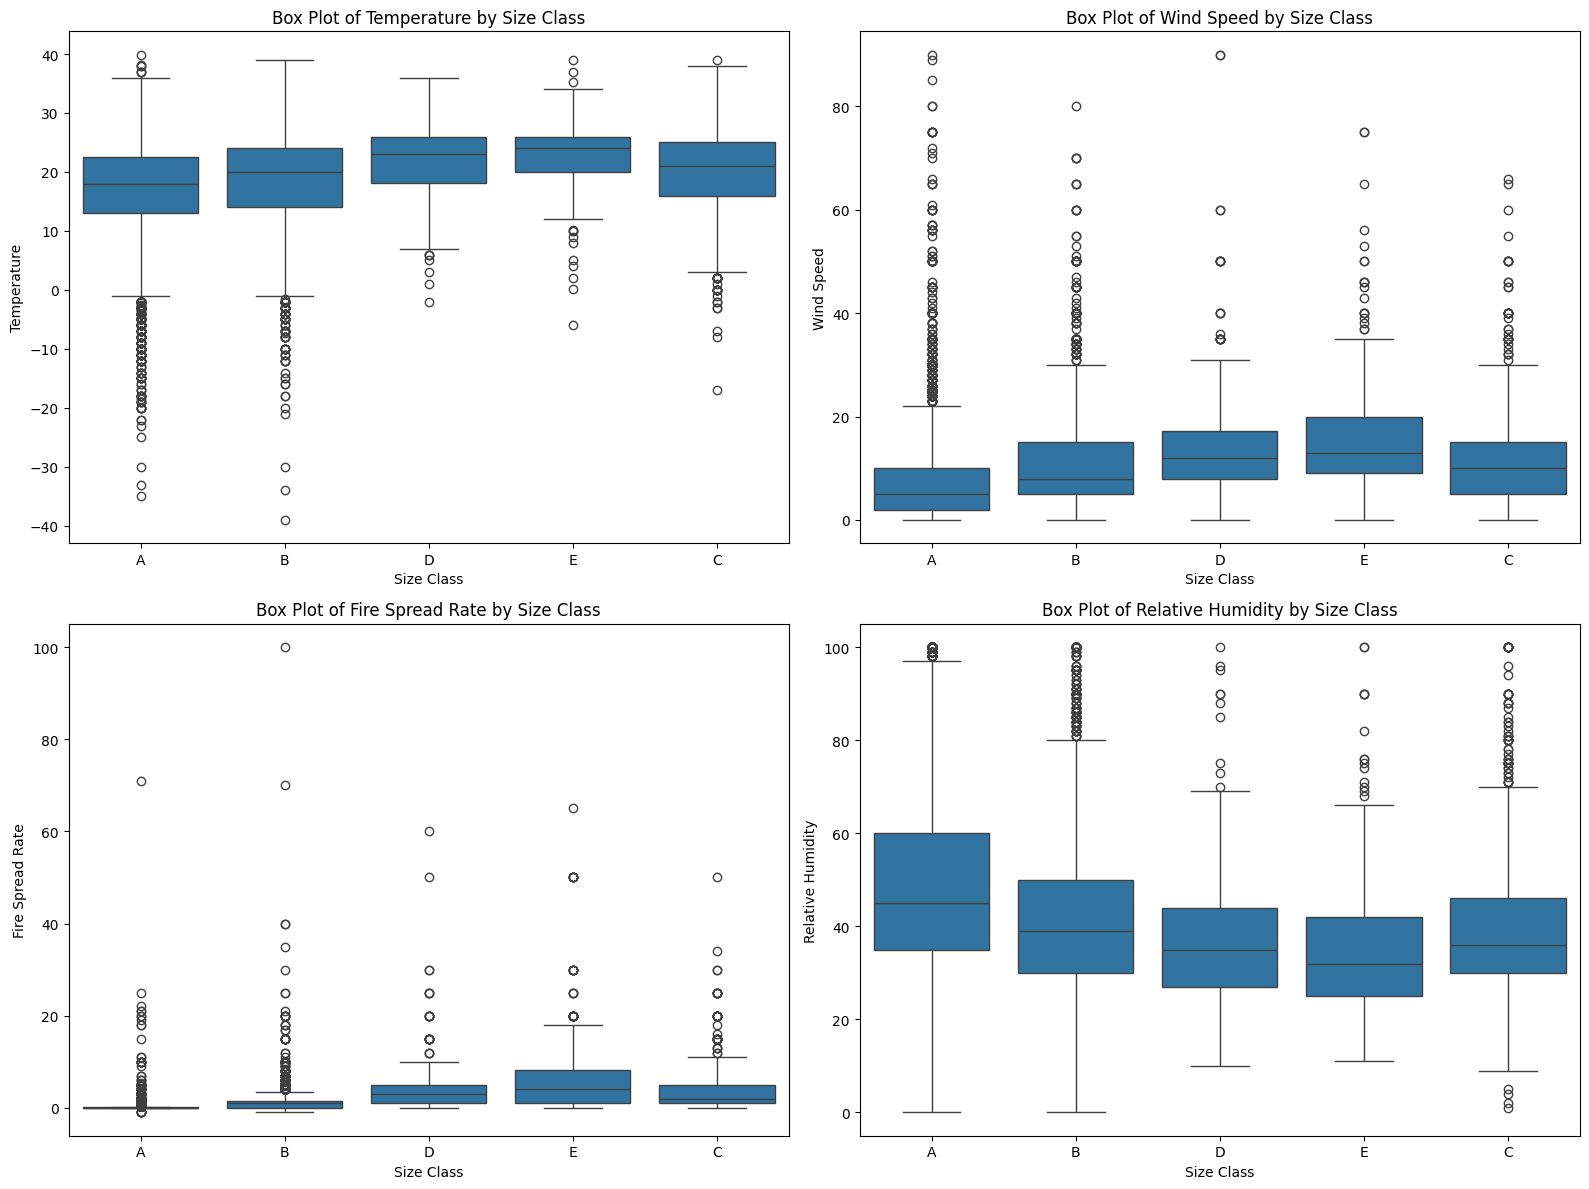

In [95]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create a box plot for temperature by size_class
sns.boxplot(x='size_class', y='temperature', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Temperature by Size Class')
axes[0, 0].set_xlabel('Size Class')
axes[0, 0].set_ylabel('Temperature')

# Create a box plot for wind_speed by size_class
sns.boxplot(x='size_class', y='wind_speed', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Wind Speed by Size Class')
axes[0, 1].set_xlabel('Size Class')
axes[0, 1].set_ylabel('Wind Speed')

# Create a box plot for fire_spread_rate by size_class
sns.boxplot(x='size_class', y='fire_spread_rate', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of Fire Spread Rate by Size Class')
axes[1, 0].set_xlabel('Size Class')
axes[1, 0].set_ylabel('Fire Spread Rate')

# Create a box plot for relative_humidity by size_class
sns.boxplot(x='size_class', y='relative_humidity', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Relative Humidity by Size Class')
axes[1, 1].set_xlabel('Size Class')
axes[1, 1].set_ylabel('Relative Humidity')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Comparison of Total Current Size and Number of Fires by Year:
    fire_year  current_size  count
0        2006     118761.87   1954
1        2007     103668.54   1348
2        2008      20786.91   1712
3        2009      66947.44   1710
4        2010      81223.74   1840
5        2011     806054.64   1218
6        2012     385657.86   1568
7        2013      19575.84   1226
8        2014      23704.53   1470
9        2015     466330.48   1898
10       2016     507134.11   1376
11       2017      49130.33   1244
12       2018      54882.68   1279
13       2019     791838.41   1005
14       2020       3274.45    723
15       2021      54088.58   1342
16       2022     131271.77   1276
17       2023    2211873.23   1132


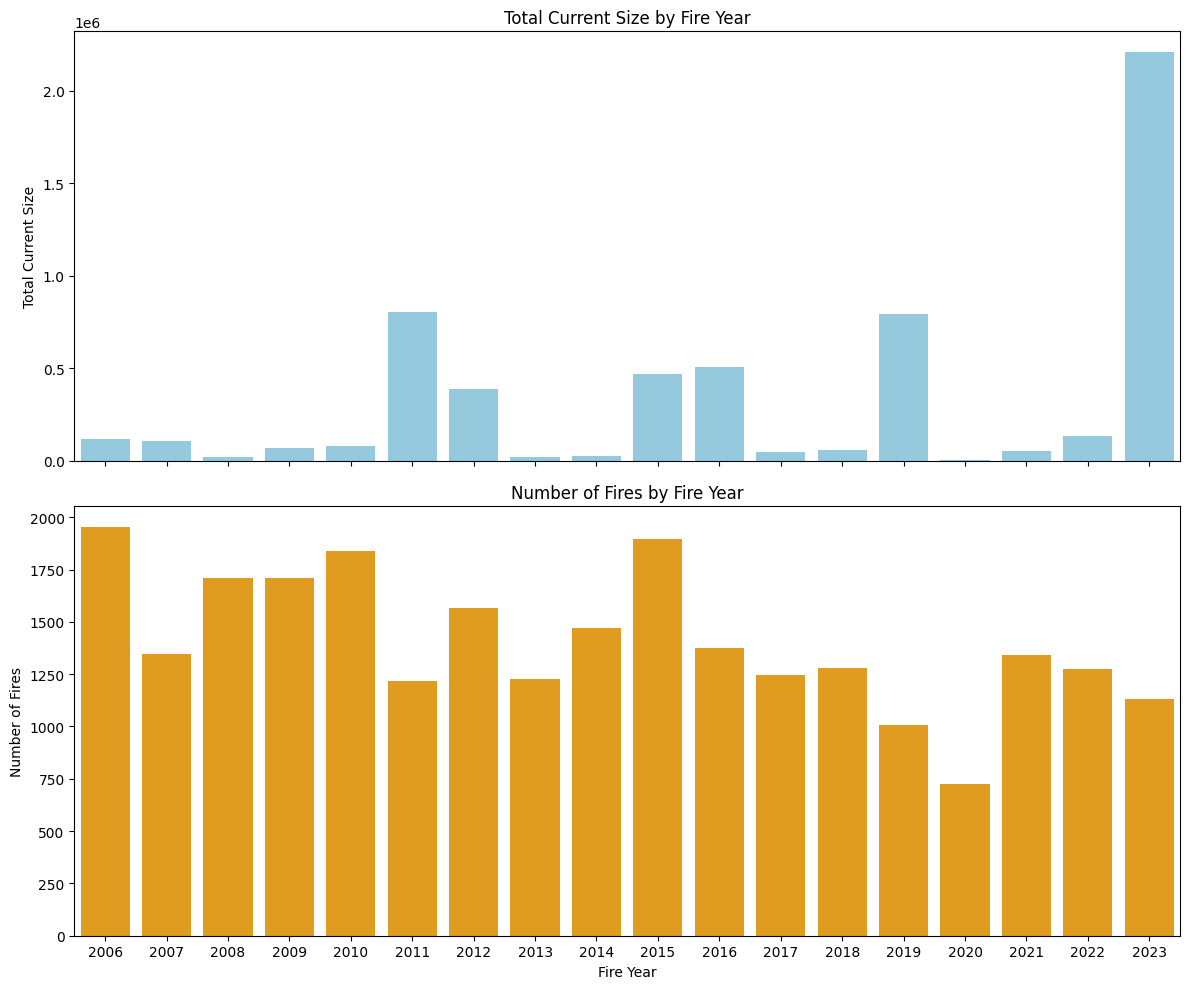

In [96]:
# Group by fire_year and calculate the mean current_size and count of items
grouped_df = data.groupby('fire_year').agg({'current_size': 'sum', 'size_class': 'count'}).reset_index()
grouped_df.rename(columns={'size_class': 'count'}, inplace=True)

# Convert fire_year to integer (ensure it's already integer in your original dataframe)
grouped_df['fire_year'] = grouped_df['fire_year'].astype(int)

# Display as a table
print("Comparison of Total Current Size and Number of Fires by Year:")
print(grouped_df)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Bar plot for Total Current Size
sns.barplot(data=grouped_df, x='fire_year', y='current_size', ax=ax1, color='skyblue')
ax1.set_title('Total Current Size by Fire Year')
ax1.set_ylabel('Total Current Size')

# Bar plot for Number of Fires
sns.barplot(data=grouped_df, x='fire_year', y='count', ax=ax2, color='orange')
ax2.set_title('Number of Fires by Fire Year')
ax2.set_xlabel('Fire Year')
ax2.set_ylabel('Number of Fires')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

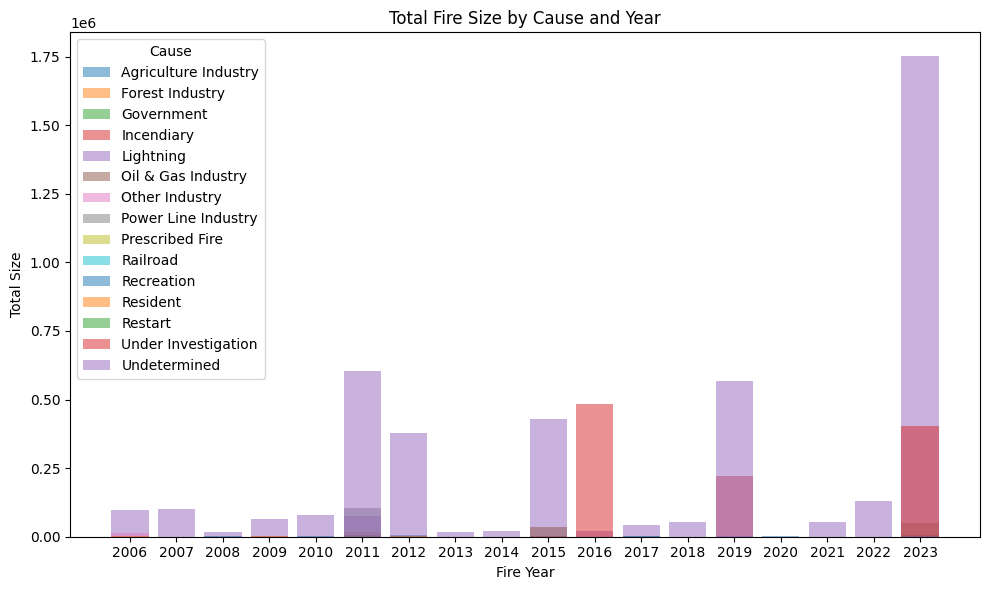

In [97]:
grouped_data = data.groupby(['general_cause_desc', 'fire_year'])['current_size'].sum().reset_index()

plt.figure(figsize=(10, 6)) 
# Iterate over unique general_cause_desc values for separate bars
for i, cause in enumerate(grouped_data['general_cause_desc'].unique()):
    plt.bar(
        grouped_data[grouped_data['general_cause_desc'] == cause]['fire_year'],
        grouped_data[grouped_data['general_cause_desc'] == cause]['current_size'],
        label=cause,
        alpha=0.5
    )

plt.xlabel('Fire Year')
plt.ylabel('Total Size')
plt.title('Total Fire Size by Cause and Year')
plt.xticks(grouped_data['fire_year'].unique())
plt.legend(title='Cause')

plt.tight_layout()
plt.show()
